**Quinto Trabalho**

**Nome:Valéria Cristina A. R. de Figueredo**

# Introdução às Redes Convolucionais com PyTorch

Neste notebook, vamos explorar Redes Neurais usando a biblioteca PyTorch. Vamos começar com uma Rede Neural Totalmente Conectada (Fully Connected Network) para classificar dígitos do dataset MNIST. Em seguida, substituiremos a rede por uma Rede Neural Convolucional (CNN) e compararemos os resultados.

## Objetivos
- Carregar e preprocessar o dataset MNIST.
- Implementar uma Rede Neural Totalmente Conectada.
- Treinar e avaliar a rede.
- Substituir a rede por uma CNN e comparar os resultados.

In [1]:
# Importando as bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
# from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

## Carregando e Preprocessando o Dataset MNIST

O dataset MNIST contém 60.000 imagens de treinamento e 10.000 imagens de teste de dígitos manuscritos, de 0 a 9.

In [2]:
# Download do dataset MNIST into data dir
! wget https://pjreddie.com/media/files/mnist_train.csv -P data

--2024-12-14 02:06:10--  https://pjreddie.com/media/files/mnist_train.csv
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109575994 (104M) [text/csv]
Saving to: ‘data/mnist_train.csv’

mnist_train.csv     100%[===================>] 104.50M  13.3MB/s    in 6.8s    

2024-12-14 02:06:17 (15.4 MB/s) - ‘data/mnist_train.csv’ saved [109575994/109575994]



In [3]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file, header=None)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # A primeira coluna é o rótulo
        label = self.data.iloc[idx, 0]
        # As demais colunas são os pixels da imagem
        image = self.data.iloc[idx, 1:].values.astype('uint8').reshape(28, 28)

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToPILImage(),    # Convertendo o array numpy para imagem PIL
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

In [5]:
# Criando índices aleatórios para os subsets de treino e teste
indices = np.arange(len(mnist_dataset))
np.random.shuffle(indices)

train_indices = indices[:10000]  # Primeiros 10.000 índices para o trainset
test_indices = indices[10000:11000]  # Próximos 1.000 índices para o testset

trainset = Subset(mnist_dataset, train_indices)
testset = Subset(mnist_dataset, test_indices)

In [6]:
# Criando DataLoaders para os subsets
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

## Visualizando Algumas Imagens do Dataset

Vamos visualizar algumas imagens do dataset de treino para entender melhor os dados com os quais estamos trabalhando.

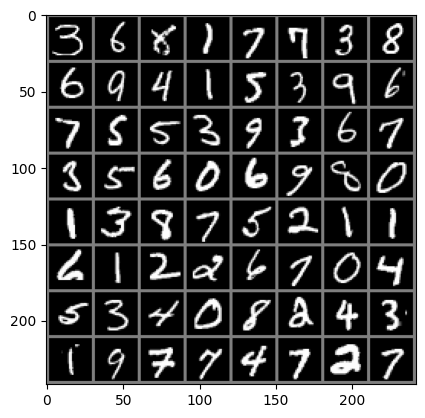

Labels:  3 6 8 1 7 7 3 8


In [7]:
# Função para mostrar uma imagem
def imshow(img):
    img = img / 2 + 0.5  # desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# Obter algumas imagens de treinamento
images, labels = next(iter(trainloader))

# Mostrar imagens
imshow(torchvision.utils.make_grid(images))
# Mostrar labels
print('Labels: ', ' '.join('%d' % labels[j] for j in range(8)))

In [8]:
def train_model(model, trainloader, criterion, optimizer, num_epochs=5):
    train_losses = []
    accuracies = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            # Obter os inputs; data é uma lista de [inputs, labels]
            inputs, labels = data

            # Zerar os gradientes dos parâmetros otimizados
            optimizer.zero_grad()

            # forward + backward + otimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Estatísticas
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i % 50 == 49:
                train_losses.append(running_loss / 100)
                running_loss = 0.0

        epoch_acc = 100 * correct / total
        accuracies.append(epoch_acc)
        print(f'Epoch {epoch+1}, Loss: {train_losses[-1]:.3f}, Accuracy: {epoch_acc:.2f}%')
    print('Treinamento concluído')
    return train_losses, accuracies


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Definindo a Rede Neural Totalmente Conectada

Vamos definir uma arquitetura simples de Rede Neural Totalmente Conectada (FCN).

In [9]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

fcn_model = FCN()


In [10]:
fcn_params = count_parameters(fcn_model)
print(f"Total de parâmetros na FCN: {fcn_params}")

Total de parâmetros na FCN: 109386


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fcn_model.parameters(), lr=0.01, momentum=0.9)

In [12]:
# Treinando a FCN
fcn_losses, fcn_accuracies = train_model(fcn_model, trainloader, criterion, optimizer)

100%|██████████| 157/157 [00:07<00:00, 21.67it/s]


Epoch 1, Loss: 0.245, Accuracy: 66.49%


100%|██████████| 157/157 [00:06<00:00, 25.21it/s]


Epoch 2, Loss: 0.197, Accuracy: 87.80%


100%|██████████| 157/157 [00:07<00:00, 20.99it/s]


Epoch 3, Loss: 0.152, Accuracy: 90.02%


100%|██████████| 157/157 [00:06<00:00, 24.64it/s]


Epoch 4, Loss: 0.120, Accuracy: 91.95%


100%|██████████| 157/157 [00:08<00:00, 19.44it/s]

Epoch 5, Loss: 0.112, Accuracy: 93.01%
Treinamento concluído


In [13]:
# Testando a FCN
test_model(fcn_model, testloader)

Acurácia da rede na base de teste: 92.20%


## Substituindo a Rede Neural por uma CNN

Agora, vamos substituir a Rede Neural Totalmente Conectada por uma Rede Neural Convolucional (CNN) e comparar os resultados.

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.fc1 = nn.Linear(12 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 12 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

cnn_model = CNN()

In [15]:
cnn_params = count_parameters(cnn_model)
print(f"Total de parâmetros na CNN: {cnn_params}")

Total de parâmetros na CNN: 14970


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_model.parameters(), lr=0.01, momentum=0.9)

In [17]:
# Treinando a CNN
cnn_losses, cnn_accuracies = train_model(cnn_model, trainloader, criterion, optimizer)

100%|██████████| 157/157 [00:08<00:00, 18.79it/s]


Epoch 1, Loss: 0.187, Accuracy: 64.89%


100%|██████████| 157/157 [00:09<00:00, 17.36it/s]


Epoch 2, Loss: 0.080, Accuracy: 93.80%


100%|██████████| 157/157 [00:07<00:00, 20.34it/s]


Epoch 3, Loss: 0.065, Accuracy: 95.76%


100%|██████████| 157/157 [00:08<00:00, 17.67it/s]


Epoch 4, Loss: 0.049, Accuracy: 97.07%


100%|██████████| 157/157 [00:08<00:00, 17.86it/s]

Epoch 5, Loss: 0.039, Accuracy: 97.31%
Treinamento concluído


In [18]:
# Testando a CNN
test_model(cnn_model, testloader)

Acurácia da rede na base de teste: 97.40%


## Comparando as duas redes neurais

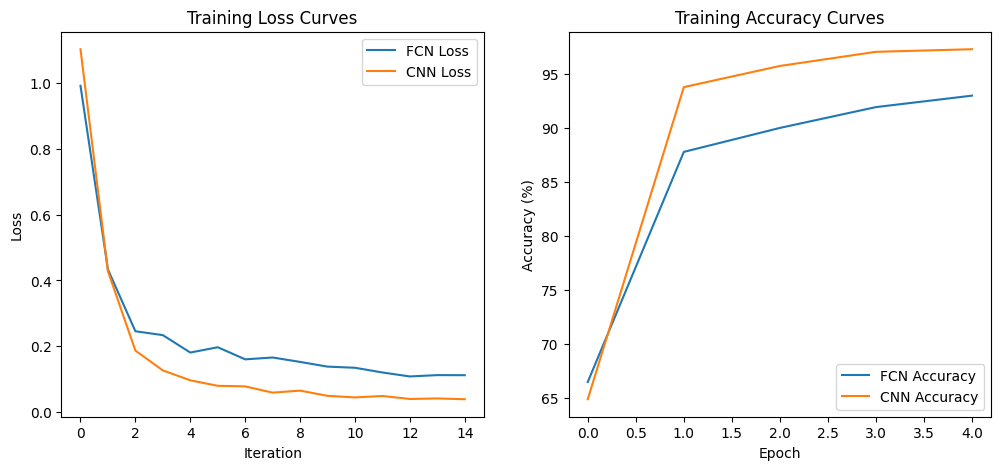

In [19]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fcn_losses, label='FCN Loss')
plt.plot(cnn_losses, label='CNN Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fcn_accuracies, label='FCN Accuracy')
plt.plot(cnn_accuracies, label='CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Curves')
plt.legend()

plt.show()

## Exercícios

### Exercício 1
Altere a estrutura da rede e diminua o número de parâmetros na rede FC. O que se observa no resultado do treinamento?

In [44]:
class FCN2(nn.Module):
    def __init__(self):
        super(FCN2, self).__init__()
        # Alteração no número de neurônios para diminuir os parâmetros
        self.fc1 = nn.Linear(28 * 28, 64)  # Reduzido de 128 para 64
        self.fc2 = nn.Linear(64, 32)       # Reduzido de 64 para 32
        self.fc3 = nn.Linear(32, 10)       # Camada de saída permanece igual (10 classes)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Achata a entrada de 28x28 para um vetor 1D de 784 elementos
        x = F.relu(self.fc1(x))  # Aplica ReLU na camada 1
        x = F.relu(self.fc2(x))  # Aplica ReLU na camada 2
        x = self.fc3(x)          # Aplica a camada de saída (sem ativação aqui)
        return x

fcn_model_2 = FCN2()

fcn_params = count_parameters(fcn_model_2)
print(f"Total de parâmetros na FCN: {fcn_params}")

# Verificando a arquitetura e o número de parâmetros
print(fcn_model_2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fcn_model_2.parameters(), lr=0.01, momentum=0.9)


# Treinando a FCN2
fcn_losses, fcn_accuracies = train_model(fcn_model_2, trainloader, criterion, optimizer)

# Testando a FCN2
test_model(fcn_model_2, testloader)

Total de parâmetros na FCN: 52650
FCN2(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


100%|██████████| 157/157 [00:06<00:00, 23.42it/s]


Epoch 1, Loss: 0.252, Accuracy: 68.02%


100%|██████████| 157/157 [00:06<00:00, 24.14it/s]


Epoch 2, Loss: 0.192, Accuracy: 87.09%


100%|██████████| 157/157 [00:06<00:00, 24.34it/s]


Epoch 3, Loss: 0.163, Accuracy: 89.83%


100%|██████████| 157/157 [00:06<00:00, 23.44it/s]


Epoch 4, Loss: 0.133, Accuracy: 91.52%


100%|██████████| 157/157 [00:06<00:00, 25.70it/s]


Epoch 5, Loss: 0.112, Accuracy: 92.76%
Treinamento concluído
Acurácia da rede na base de teste: 90.30%


Nessa nova estrutura de rede, o total de parâmetros na FCN mudou: saiu de 109386 para 52650. Da mesma forma, a acurácia de treino e teste também mudou. No primeiro modelo, a acurácia de treino era 93.01% e de teste era 92.20 %. Nesse novo modelo, a acurácia de treino diminuiu para 92,76% e de teste passou para 90.30%.Portanto, a redução de parâmetros não foi positiva no aprimoramento desse modelo.

### Exercício 2
Aumente o número de filtros convolucionais na CNN. O que se observa no resultado do treinamento em comparação ao anterior? Lembre-se de ajustar os valores das camadas seguintes.

In [52]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        # Aumentando o número de filtros
        self.conv1 = nn.Conv2d(1, 10, 5)  # De 6 para 10 filtros
        self.conv2 = nn.Conv2d(10, 20, 5)  # De 10 para 20 filtros
        self.fc1 = nn.Linear(20 * 4 * 4, 64)  # Atualizando o tamanho da entrada para a camada totalmente conectada
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 20 * 4 * 4)  # Atualizando o tamanho após a segunda camada convolucional
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

# Instanciando o modelo
cnn_model2 = CNN2()

# Verificando a arquitetura e o número de parâmetros
print(cnn_model2)

cnn_params2 = count_parameters(cnn_model2)
print(f"Total de parâmetros na CNN: {cnn_params2}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_model2.parameters(), lr=0.01, momentum=0.9)

# Treinando a CNN
cnn_losses, cnn_accuracies = train_model(cnn_model2, trainloader, criterion, optimizer)

# Testando a CNN
test_model(cnn_model2, testloader)



CNN2(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)
Total de parâmetros na CNN: 26474


100%|██████████| 157/157 [00:10<00:00, 14.70it/s]


Epoch 1, Loss: 0.178, Accuracy: 65.60%


100%|██████████| 157/157 [00:10<00:00, 15.33it/s]


Epoch 2, Loss: 0.081, Accuracy: 94.39%


100%|██████████| 157/157 [00:09<00:00, 16.22it/s]


Epoch 3, Loss: 0.053, Accuracy: 96.14%


100%|██████████| 157/157 [00:09<00:00, 16.22it/s]


Epoch 4, Loss: 0.044, Accuracy: 97.11%


100%|██████████| 157/157 [00:10<00:00, 15.04it/s]


Epoch 5, Loss: 0.032, Accuracy: 97.54%
Treinamento concluído
Acurácia da rede na base de teste: 97.50%


A acurácia do antigo modelo foi 97.31% (treino) e 97.40% (teste). E com esse novo modelo, com o aumento de parâmetros de 14970 para 26474, a acurácia melhorou para 97.54% (treino) e 97.50% (teste).Portanto, o aumento de parâmetros foi positivo no aprimoramento desse modelo.